In [7]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [8]:
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root = 'data/TUDataset',name='PROTEINS',use_node_attr=True).shuffle()

print(torch_geometric.__version__)
print(f'Number of graphs {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

2.1.0
Number of graphs 1113
Number of features: 4
Number of classes: 2


edge_index means there are 134 edges. X is the feature matrix with 37 nodes and feature vector of size 0. Just a single value for the label, thus classification

In [5]:
type(dataset[0])

torch_geometric.data.data.Data

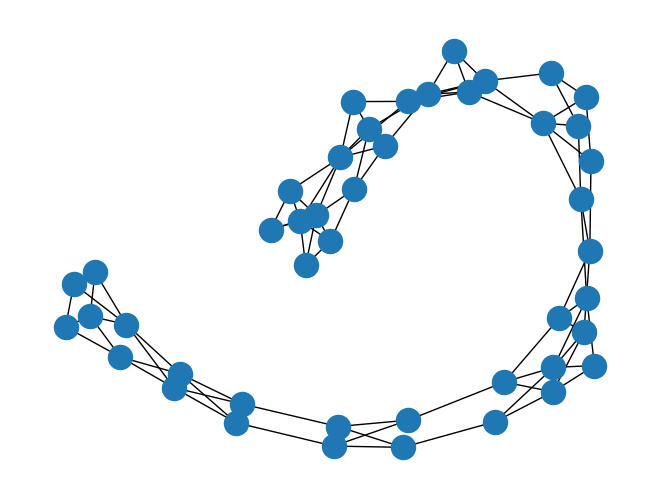

In [39]:
G = to_networkx(dataset[100],to_undirected=True)

nx.draw(G)
plt.show()

In [10]:
train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset  = dataset[int(len(dataset)*0.8):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training set   = 890 graphs
Test set       = 223 graphs


In [11]:
tmp = [x for x in train_loader]
print(len(train_loader))
print(train_dataset)
print(tmp)

14
PROTEINS(890)
[DataBatch(edge_index=[2, 7736], x=[2070, 4], y=[64], batch=[2070], ptr=[65]), DataBatch(edge_index=[2, 8586], x=[2369, 4], y=[64], batch=[2369], ptr=[65]), DataBatch(edge_index=[2, 8424], x=[2270, 4], y=[64], batch=[2270], ptr=[65]), DataBatch(edge_index=[2, 8772], x=[2367, 4], y=[64], batch=[2367], ptr=[65]), DataBatch(edge_index=[2, 8086], x=[2196, 4], y=[64], batch=[2196], ptr=[65]), DataBatch(edge_index=[2, 9710], x=[2578, 4], y=[64], batch=[2578], ptr=[65]), DataBatch(edge_index=[2, 10714], x=[2929, 4], y=[64], batch=[2929], ptr=[65]), DataBatch(edge_index=[2, 9678], x=[2565, 4], y=[64], batch=[2565], ptr=[65]), DataBatch(edge_index=[2, 9240], x=[2359, 4], y=[64], batch=[2359], ptr=[65]), DataBatch(edge_index=[2, 10510], x=[2845, 4], y=[64], batch=[2845], ptr=[65]), DataBatch(edge_index=[2, 12972], x=[3575, 4], y=[64], batch=[3575], ptr=[65]), DataBatch(edge_index=[2, 8286], x=[2179, 4], y=[64], batch=[2179], ptr=[65]), DataBatch(edge_index=[2, 7548], x=[2004, 4]

In [23]:
dataset[40].y

tensor([0])

In [13]:
from torch_geometric.nn import GINConv, GCNConv
from torch.nn import Linear, BatchNorm1d, Sequential, ReLU
from torch_geometric.nn import global_add_pool, global_mean_pool
import torch.nn.functional as F
class GIN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim),
                       BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        self.linear = Linear(dim*3, dataset.num_classes)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)

        h1 = global_add_pool(h1)
        h2 = global_add_pool(h2)
        h3 = global_add_pool(h3)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.linear(h)
        
        return h
gin = GIN(64)

In [14]:
class GNN(nn.Module):
    def __init__(self, dim, num_class):
        super().__init__()
        self.conv1 = GCNConv(dim,64)
        self.conv2 = GCNConv(64,64)
        self.conv3 = GCNConv(64,64)
        self.lin = nn.Linear(64,num_class)
    def forward(self, x, edge_index,batch):
        x = F.relu(self.conv1(x,edge_index))
        x = F.relu(self.conv2(x,edge_index))
        x = self.conv3(x,edge_index)
        x = global_mean_pool(x,batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x
model = GNN(dim=4,num_class=2)
        

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.01)
crit = nn.CrossEntropyLoss()
def train():
    model.train()

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x,data.edge_index,data.batch)
        print(out)
        print(data.y)
        loss = crit(out,data.y)
        loss.backward()
        optimizer.step()

In [17]:
def test(test_loader):
    model.eval()
    correct = 0
    for data in test_loader:
        pred = model(data.x, data.edge_index,data.batch).argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(test_loader.dataset)

In [25]:
for epoch in range(2):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

tensor([[ 0.2462, -0.1556],
        [ 0.2214, -0.1161],
        [ 0.2223, -0.1290],
        [ 0.1727, -0.1716],
        [ 0.1428, -0.0759],
        [ 0.2753, -0.0893],
        [ 0.2446, -0.1715],
        [ 0.3355, -0.6664],
        [ 0.1999, -0.1364],
        [ 0.2007, -0.1489],
        [ 0.1646, -0.1608],
        [ 0.2126, -0.1493],
        [ 0.2767, -0.1225],
        [ 0.2223, -0.1132],
        [ 0.2187, -0.1241],
        [ 0.2242, -0.1796],
        [ 0.1867, -0.1938],
        [ 0.2216, -0.1376],
        [ 0.2275, -0.1091],
        [ 0.2840, -0.1116],
        [ 0.2008, -0.1454],
        [ 0.3000, -0.0616],
        [ 0.2786, -0.1399],
        [ 0.2191, -0.1550],
        [ 0.2851, -0.1287],
        [ 0.2015, -0.1692],
        [ 0.2420, -0.1395],
        [ 0.2260, -0.1215],
        [ 0.1959, -0.1708],
        [ 0.2736, -0.1799],
        [ 0.1441, -0.1492],
        [ 0.1422, -0.1840],
        [ 0.2144, -0.1336],
        [ 0.1980, -0.1280],
        [ 0.2747, -0.1460],
        [ 0.2652, -0

In [98]:
xx = model(data.x, data.edge_index,data.batch)
print(xx[2])
print(xx.argmax(dim=1))

tensor([ -0.1975,   0.7116,  -0.2682, -10.3509,  -0.0205,   0.2572],
       grad_fn=<SelectBackward0>)
tensor([4, 4, 1, 5, 5, 5, 2, 5, 4, 2, 5, 5, 2, 2, 2, 2, 5, 2, 2, 2, 5, 1, 5, 0,
        4, 0, 0, 1, 1, 4, 5, 4, 4, 5, 4, 2, 4, 5, 4, 2, 5, 1, 2, 0, 2, 2, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2])


In [29]:
from torch_geometric.data import Data
class PairData(Data):
    def __init__(self, x_s=None, edge_index_s=None, edge_attr_s=None, x_t=None, edge_index_t=None, edge_attr_t=None, y=None):
        super().__init__()
        self.x_s = x_s
        self.edge_index_s = edge_index_s
        self.edge_attr_s = edge_attr_s
        self.x_t = x_t
        self.edge_index_t = edge_index_t
        self.edge_attr_t = edge_attr_t
        self.y = y

    @property
    def num_nodes_s(self):
        return self.x_s.size(0) + self.x_t.size(0)

    @property
    def num_node_features(self):
        return self.x_s.size(1)

    def __inc__(self, key, value,*args,**kwargs):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        return super().__inc__(key, value,*args,**kwargs)

In [35]:
from torch_geometric.loader import DataLoader
x_s = torch.randn(5, 16)  # 5 nodes.
edge_index_s = torch.tensor([
    [0, 0, 0, 0],
    [1, 2, 3, 4],
])

x_t = torch.randn(4, 16)  # 4 nodes.
edge_index_t = torch.tensor([
    [0, 0, 0],
    [1, 2, 3],
])

x_s2 = torch.randn(4, 16)  # 5 nodes.
edge_index_s2 = torch.tensor([
    [0, 0, 0],
    [1, 2, 3],
])

x_t2 = torch.randn(8, 16)  # 8 nodes.
edge_index_t2 = torch.tensor([
    [0, 0, 0,0,0,0,0],
    [1, 2, 3,4,5,6,7],
])

data = PairData(x_s=x_s, edge_index_s=edge_index_s,
                x_t=x_t, edge_index_t=edge_index_t)
data2 = PairData(x_s=x_s2, edge_index_s=edge_index_s2,
                x_t=x_t2, edge_index_t=edge_index_t2)

data_list = [data, data2]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

In [36]:
print(data_list[0])
print(data_list[1])
print(batch)
data_list[0].x_s

PairData(x_s=[5, 16], edge_index_s=[2, 4], x_t=[4, 16], edge_index_t=[2, 3])
PairData(x_s=[4, 16], edge_index_s=[2, 3], x_t=[6, 16], edge_index_t=[2, 5])
PairDataBatch(x_s=[9, 16], edge_index_s=[2, 7], x_t=[10, 16], edge_index_t=[2, 8])


tensor([[-0.3144,  1.5240, -1.8483, -0.6386,  1.4040,  1.9529, -0.0374,  0.7563,
         -1.8339, -0.8719,  0.3636, -0.7987, -0.3922, -2.3634,  1.6945,  0.9381],
        [ 2.1722,  0.8373,  0.8522,  0.5936,  0.0869,  0.2534,  0.5274,  0.6234,
         -0.1964, -0.8286, -0.3023,  1.5491,  0.3758, -0.0859, -0.2488,  0.3136],
        [-0.3858,  0.6251,  0.4842,  1.2398,  1.7413,  1.5813, -0.1043, -1.5292,
          0.3383, -1.1786, -0.7964,  0.1180, -0.5226,  0.2237,  0.7693, -0.5820],
        [-0.0704,  0.5973, -1.7285, -0.7973, -1.0201, -0.0964, -1.9312, -1.3098,
         -0.2114,  0.3356, -0.7591, -0.6281,  0.3221,  1.2648,  1.2268, -0.5080],
        [ 0.8696,  0.3752, -0.8855,  0.2468,  0.0479,  0.0923,  0.2633,  0.2872,
         -0.7528, -0.5081,  0.9032,  0.2172,  0.5400, -0.2661,  0.7780,  1.3648]])

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import NNConv

# Set up a sample graph with edge features
edge_index = torch.tensor([[0, 1, 2,1,0,2,3], [1, 2, 0,3,4,3,4]], dtype=torch.long)
edge_attr1 = torch.tensor([0.5, 1.0, 1.5,2.0,3.0,4.0,1.5], dtype=torch.float)
edge_attr2 = torch.tensor([2.0, 3.0, 4.0,1.5,2.4,5,2,5,2], dtype=torch.float)
x = torch.randn(5, 16)  # Node features

# Define the neural network for edge features
nn = torch.nn.Sequential(torch.nn.Linear(2, 8), torch.nn.ReLU(), torch.nn.Linear(8, 16*8))

# Define the convolutional layer
conv = NNConv(16, 8, nn=nn)

# Apply the convolution to the node features with the edge features
edge_attr = torch.stack([edge_attr1, edge_attr2], dim=1)  # Combine edge attributes
print(edge_attr.shape)
print(x.shape)
print(edge_index.shape)
out = conv(x, edge_index, edge_attr)

# Print the output shape
print(out.shape)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1299512858.py, line 7)

In [4]:
x = torch.randn(3, 16)
x

tensor([[ 0.2951,  1.2681,  0.0886,  1.4553, -0.0729, -0.9623, -1.4682, -0.0616,
          1.4149,  1.4469,  0.0571, -0.0034, -0.9597, -0.0919,  0.1517, -0.2136],
        [ 0.9148, -0.6345,  1.5995,  1.1828, -0.4730, -0.1389,  1.2141,  0.4415,
          1.4860, -1.7630, -0.5347, -0.4332, -0.4121,  0.5066, -0.1272,  1.8247],
        [ 0.5076, -1.1700, -1.4217, -0.1545, -0.9185,  1.3538,  0.5165, -1.1971,
         -0.2191, -0.4968,  0.2763, -0.3780, -0.0638,  0.2486, -0.0417, -0.5315]])